In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray()
!pip install opencv-python
import cv2 
%matplotlib inline

# Convolutional Neural Networks mit Keras

Für sehr komplexe Datensätze, für die ein hohes Maß an Abstraktionsfähigkeit und Generalisierbarkeit aufgebracht werden muss, sind "klassische" Machine Learning Methoden meist nicht anwendbar. In vielen Bereichen können nur Deep Neural Networks mit einer großen Zahl an Parametern die nichtlinearen Relationen mit einer akzeptablen Genauigkeit abbilden. Dazu zählen vor allem Themen wie Bildklassifikation bzw. Objekterkennung. Die Klassifikation eines Bildes als Hund oder Katze stellt für einen Menschen keine Herausforderung dar, einem neuronalen Netz allerdings kann dies erst mit einer großen Anzahl an Trainingsbildern und einer sehr speziellen Netzarchitektur gelingen.

## Aufgabe 1: Bilder als 1-D Vektoren

In den vorherigen Übungen haben wir die Datensätze stets als 1-D Vektoren in einen Klassifikator gespeist. Dies könnte auch für Bilder ein erster Ansatz sein. Dazu wollen wir zunächst berechnen, wie viele Parameter ein Neuronales Netz benötigt, welches Bilder mit einer Größe von 28x28 Pixeln einließt und eine von 10 Klassen ausgibt. Die Anzahl an Parametern, die ein voll zusammenhängendes Neuronales Netz besitzt lässt sich berechnen mit $$N_P = \sum_{i=1}^{L-1} (n_i \cdot n_{i+1} + n_{i+1})$$ mit der Anzahl der Neuronen $n_i$ im $i$-ten Layer und einer Gesamtanzahl von Layern $L$. 

<img src="skizze.jpg" alt="Drawing" style="width: 600px;"/>

a) Wie viele Parameter besitzt ein Neuronales Netz, das zwei versteckte Layer besitzt mit der gleichen Größe, wie der Input Layer? Schreibe eine Funktion in Python, die die Parameteranzahl ausrechnet. Sie soll als Argument eine Liste erhalten mit der Anzahl der Neuronen in jedem Layer. 

Insgesamt 1238730 Parameter.



In [25]:
def parameters(layers) :
    i=0
    N_p=0
    while i<3:
        N_p = N_p + (layers[i]+1)*layers[i+1]
        i +=1
        print(N_p)
        

In [26]:
layers = [784, 784, 784, 10]
parameters(layers)

615440
1230880
1238730


b) Wie viele Parameter ergeben sich für ein Bild der Größe 200x200 mit dieser Methode? Wie verhält es sich bei einem Bild mit Full HD-Auflösung? Welche Probleme ergeben sich?

jeweils 3200480010 und 2720991916810. Aufgrund der großen Anzahl von Parametern in der voll zusammenhängendes Neuronales Netz steigt jedoch die Komplexität des Modells. Es wird sich Overfitting ergeben.

In [28]:
layers = [40000,40000,40000,10]
parameters(layers)

1600040000
3200080000
3200480010


In [29]:
layers = [1080*1080,1080*1080,1080*1080,10]
parameters(layers)

1360490126400
2720980252800
2720991916810


## Aufgabe 2: Filter aus der Computer Vision

Im vorherigen Ansatz ist jeder Pixel aus dem eingespeisten Bild mit jedem Neuron aus dem nachvolgenden Layer verbunden. In Bildern sind Informationen jedoch häufig lokal zentriert. Daher ist ein nächster Ansatz, dass ein Neuron aus dem zweiten Layer nur Informatione zu benachbarten Pixeln im ursprünglichen Bild erhält. Dadurch kann die Anzahl der benötigten Parameter stark reduziert werden. 
In der klassischen Bildverarbeitung werden dafür meist Filter definiert, die über das Bild gelegt werden und so beispielsweise Kanten in einem Bild detektieren können. Diesen Ansatz möchten wir im Folgenden weiter untersuchen.

a) Lies das Bild ```digit_7.jpg``` mit der Größe $M$x$M$ mit $M=28$ mithilfe von OpenCV (cv2) ein. Hinweis: Lies das Bild im Graustufen-Modus ein.
Lass dir das Bild anschließend in Juypter Notebook anzeigen (das funktioniert am besten mit der matplotlib-Bibliothek)

In [ ]:
bild=cv2.imread('./digit_7.jpg')
cv2.imshow('bild',bild)
cv2.waitKey()
cv2.destroyAllWindows()                

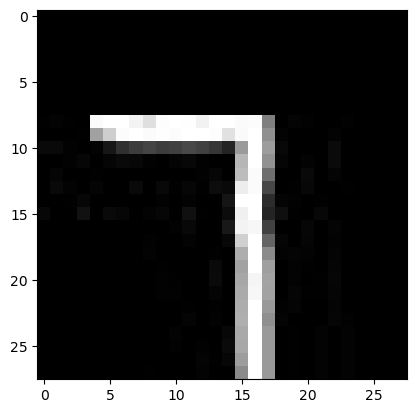

In [8]:
plt.imshow(plt.imread('digit_7.jpg'), cmap='gray')
plt.show()

In [31]:
bild =plt.imread('digit_7.jpg')
print(bild)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  1   3   1   0 251 255 255 244 223 253 255 254 242 255 255 25

Wir wenden im nächsten Schritt einen vorgefertigten Filter auf das Bild an. Der Filter ist eine 3x3 Matrix und wird anschaulich über das Bild "geschoben". Dabei wird erst das Hadamard-Produkt mit einem Teil des Bildes und dem Filter gebildet und anschließend die Summe der resultierenden Matrixelemente gebildet. Dieser Vorgang wird wiederholt, bis das ganze Bild abgedeckt ist.

<img src="convolution.jpg" alt="Drawing" style="width: 600px;"/>


b) Schreibe eine Funktion, die als Argumente das Bild und den Filter $N$x$N$ jeweils als numpy Array erhält und die 2D Convolution davon ausgibt. Die 2D Convolution ist für unseren Fall gegeben als $$C_{kl} = \sum_{i, j=1}^{N} B_{i+k-1, j+l-1} \cdot F_{ij}$$ mit dem Filter $F$, dem Bild $B$ und dem Ergebnis der Convolution $C$ und funktioniert anschaulich wie oben beschrieben. Das Ergebnisbild hat die Dimension $M-N+1$ Hinweis: Benutze die eingebauten numpy Funktionen.

In [36]:
filter_matrix = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

def Conv2(img, kernel, n, stride):
    h, w = img.shape
    res_h = ((h-n)//stride)+1 
    res_w = ((w-n)//stride)+1
    res = np.zeros([res_h, res_w])
    for i in range(res_h):
        for j in range(res_w):
            temp = img[i*stride:i*stride+n, j*stride:j*stride+n]
            temp = np.multiply(kernel, temp)
            res[i][j] = temp.sum()
    return res

if __name__ == '__main__':

   
    print("result：",Conv2(bild, filter_matrix, 3, 1))


result： [[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.]
 [   0.    3. 

c) Was kommt heraus, wenn du den Filter auf das Bild anwendest? Kannst du mit der gleichen Funktion auch vertikale Kanten hervorheben? Lass dir beide transformierte Bilder anzeigen!

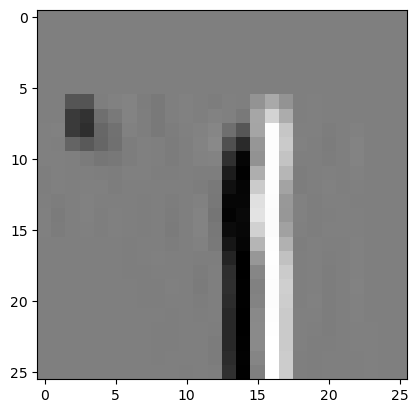

In [37]:
plt.imshow(Conv2(bild, filter_matrix, 3, 1))

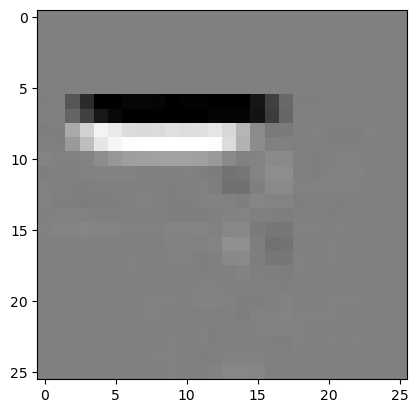

In [38]:
filter_matrix_1 = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
plt.imshow(Conv2(bild, filter_matrix_1, 3, 1))

d) Bis jetzt sind wir mit der Filtermatrix immer nur in Schritten von 1 vorangegangen. Um größere Texturen in hochaufgelösten Bildern zu erkennen, kann es aber sinnvoll sein die Schrittweite (englisch stride) auf einen größeren Wert zu setzen. Modifiziere obige Funktion und füge einen optionalen Parameter $s$ hinzu,  der die Schrittweite festlegt. Überprüfe dein Ergebnis mit $s=2$. Hinweis: Das Ergebnisbild hat nun die Dimension $\frac{M-N}{s}+1$

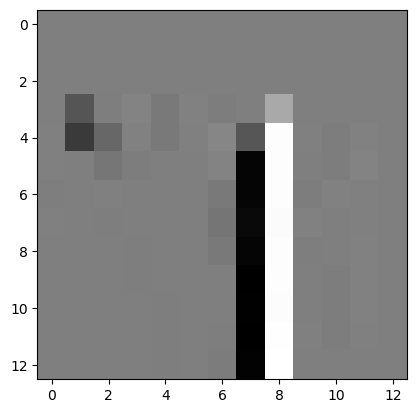

In [39]:
plt.imshow(Conv2(bild, filter_matrix, 3, 2))

Kanten lassen sich mit diesem Verfahren gut abbilden. Bei dieser Art der Covolution werden aber die Pixel am Rand des Bildes viel weniger stark gewichtet, als in der Mitte des Bildes. Um diesen Effekt abzuschwächen, kann das Bild mit Nullen an den Rändern künstlich vergrößert werden. Die eigentlichen Ränder des Bildes werden nun häufiger abgefahren und haben ein stärkeres Gewicht als vorher. Dieses Verfahren wird Padding genannt.


e) Modifiziere deine obige Funktion ein letztes Mal, um Padding zu implementieren. Frage dabei als optionalen Parameter ```padding=True/False``` ab, ob Padding durchgeführt werden soll. Die Dimension des Ergebnisbildes verändert sich nun zu $\frac{M+2p-N}{s}+1$ mit der Paddingbreite $p=\frac{(s-1)\cdot M + N - s}{2}$. Hinweis: Nutze die Funktion ```np.pad()```, wenn Padding durchgeführt werden soll.

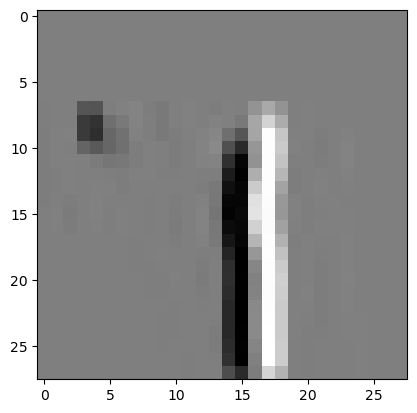

In [48]:
def Conv2p(img, kernel, n, stride, padding):

    h, w = img.shape
    if padding == True:
        p = ((stride-1)*h+n-stride)//2
    else:
        p = 0
    img = np.pad(img,((p,p),(p,p)),'constant',constant_values=0)
    res_h = ((h+2*p-n)//stride)+1 
    res_w = ((w+2*p-n)//stride)+1
    res = np.zeros([res_h, res_w])
    for i in range(res_h):
        for j in range(res_w):
            temp = img[i*stride:i*stride+n, j*stride:j*stride+n]
            temp = np.multiply(kernel, temp)
            res[i][j] = temp.sum()
    return res


if __name__ == '__main__':
    plt.imshow(Conv2p(bild, filter_matrix, 3, 1, True))


## Aufgabe 3: CNNs mit Keras und FashionMNIST

Im vorherigen Beispiel haben wir den anzuwendenden Filter vorgegeben. Der Grundgedanke eines Convolutional Neural Networks (CNN) ist es nun solche Filter via Backpropagation zu lernen, ganz analog zu einem vollständig zusammenhängenden neuronalen Netz. In jedem Convolutional Layer des Netzes wird dann nicht mehr eine große Gewichtsmatrix $W$ gelernt, sondern mehrere kleine Filtermatrizen. Die Matrizen sollen möglichst verschiedene Eigenschaften eines Bildes herausfiltern, die dann im nächsten Layer weiterverarbeitet werden können.

In vielen Fällen ist der Input des Bildes keine einfache $N \times N$-Matrix, sondern besitzt drei Farb-Kanäle (RGB). Ein Filter wird dann auf alle drei Matrizen gleichzeitig angewendet und die Zahlen werden für jeden Eintrag des Ergebnisses addiert. Auf diese Weise kann ein Convolutional Layer auch mit Inputs umgehen, die aus einem Layer mit mehreren Filtern kommen. Ein schemtischer Aufbau eines CNNs sieht dann ungefähr so aus:

<img src="Typical_cnn.png" alt="CNN" style="width: 600px;"/>


Quelle:[https://jaai.de/convolutional-neural-networks-cnn-aufbau-funktion-und-anwendungsgebiete-1691/](https://jaai.de/convolutional-neural-networks-cnn-aufbau-funktion-und-anwendungsgebiete-1691/)

Das Subsampling wird in Teilaufgabe b) nochmal genauer erläutert.



Im folgenden möchten wir ganz konkret einen Bilddatensatz einlesen und mittels TensorFlow/Keras ein CNN trainieren.

a) Importiere von ```tensorflow.keras.datasets``` den FashionMNIST-Datensatz und lies ihn als Traings- und Testdatensatz aufgeteilt ein. Lass dir einzelne Bilder des Datensatzes plotten. Was ist auf den Bildern dargestellt? Wie viele Klassen gibt es? Normiere die Pixelwerte der Bilder auf einen Wert zwischen 0 und 1.

Auf den Bildern ist ein Schuh dargestellt. 10 Klassen.

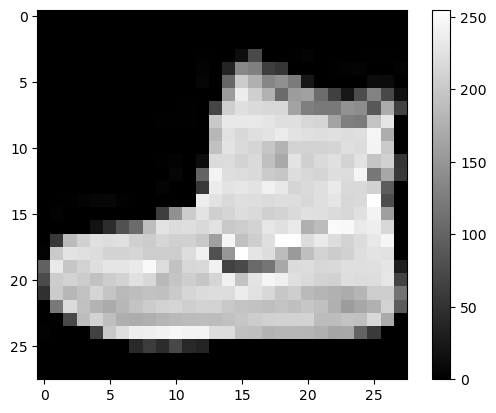

In [71]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.show


x_train = x_train/255
x_test = x_test/255

b) Für die nächste Teilaufgabe muss dem Input künstlich eine Dimension hinzugefügt werden. Wende auf ```x_train``` und ```x_test``` jeweils ```np.reshape(-1,28, 28, 1)``` an.

In [74]:
x_train = x_train.reshape(-1,28, 28, 1)
x_test = x_test.reshape(-1,28, 28, 1)


Im nächsten Schritt wollen wir ein CNN mit Keras aufbauen. Eine Abwandlung der LeNet-Architektur bietet dafür einen guten Anfang. Der Aufbau ist:
1. Convolutional Layer mit 6 Filtern und einer Filtergröße von 3x3.
2. MaxPooling Layer
3. Convolutional Layer mit 16 Filtern und einer Filtergröße von 3x3.
4. MaxPooling Layer
5. Dense Layer mit 120 Neuronen.
6. Dense Layer mit 84 Neuronen.
7. Dense Layer mit 10 Neuronen und der Softmax-Aktivierungsfunktion.

Ein MaxPooling Layer konzentrieren die Informationen des convolutional Layer, indem in jedem 2x2 Teilbereich seines Inputs das Maximum findet. Dadurch werden Höhe und Breite des Inputs jeweils halbiert.

<img src="maxpooling-2.jpg" alt="Drawing" style="width: 300px;"/>

c) Importiere ```Conv2D, MaxPooling2D``` und ```Dense``` aus ```tf.keras.layers``` und baue obige Architektur nach. Lass dir dein Modell mit ```.summary()``` ausgeben. Hinweis: Zwischen 4. und 5. muss das Array in die Form eines 1-D Vektors gebracht werden, da ```Dense``` nicht mit 2-D-Eingaben arbeiten kann.


In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

def LeNet_Architektur():
    model = Sequential()
    model.add(Conv2D(6,( 3, 3), padding='valid', input_shape=( 28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides =(2,2)))
    model.add(Conv2D(16,( 3, 3), padding='valid', input_shape=( 14, 14, 6), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides =(2,2)))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

model = LeNet_Architektur()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 6)         60        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

d) Um das Modell bereit fürs Training zu machen, wird die ```.compile()```-Methode verwendet. Dabei sollte noch die verwendete Verlustfunktion, sowie der genutze Optimierer angegeben werden. Wähle hierfür die ```sparse_categorical_crossentropy``` bzw. den Adam-Optimierer. Nutze die Accuracy als Qualitätsmetrik. Trainiere nun das Modell mit einer Batchgröße von 64 über 10 Epochen.  

In [83]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64, verbose=2)

Epoch 1/10
938/938 - 4s - loss: 0.1850 - accuracy: 0.9302 - val_loss: 0.3051 - val_accuracy: 0.8955 - 4s/epoch - 4ms/step
Epoch 2/10
938/938 - 4s - loss: 0.1740 - accuracy: 0.9337 - val_loss: 0.3147 - val_accuracy: 0.8957 - 4s/epoch - 4ms/step
Epoch 3/10
938/938 - 4s - loss: 0.1702 - accuracy: 0.9350 - val_loss: 0.3122 - val_accuracy: 0.8984 - 4s/epoch - 4ms/step
Epoch 4/10
938/938 - 4s - loss: 0.1605 - accuracy: 0.9392 - val_loss: 0.3055 - val_accuracy: 0.8990 - 4s/epoch - 4ms/step
Epoch 5/10
938/938 - 4s - loss: 0.1551 - accuracy: 0.9412 - val_loss: 0.3103 - val_accuracy: 0.8978 - 4s/epoch - 4ms/step
Epoch 6/10
938/938 - 4s - loss: 0.1480 - accuracy: 0.9428 - val_loss: 0.3466 - val_accuracy: 0.8946 - 4s/epoch - 4ms/step
Epoch 7/10
938/938 - 4s - loss: 0.1409 - accuracy: 0.9464 - val_loss: 0.3199 - val_accuracy: 0.9018 - 4s/epoch - 4ms/step
Epoch 8/10
938/938 - 4s - loss: 0.1349 - accuracy: 0.9485 - val_loss: 0.3169 - val_accuracy: 0.9014 - 4s/epoch - 4ms/step
Epoch 9/10
938/938 - 4s 

e) Die Methode ``model.fit()`` gibt ein dictionary zurück, welches Informationen über das erfolgte Training enthält. Speichere die Accuracy von Trainings- und Testdaten und plotte sie über die Epochen für unterschiedliche Batch-Größen.

In [85]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Die Accuracy ist " ,'%.2f' %(scores[1]*100) , "%")

Die Accuracy ist  89.41 %


In [ ]:
plt.plot(epochs, batch_size)